# Prédire les sinistres (demande d'indemnisation)

*(Si vous n’avez pas ces packages, installez‑les avec `pip install pandas seaborn matplotlib`.)*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage plus lisible
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Chargement du jeu de données
Nous utilisons un fichier CSV contenant :

| Colonne | Signification | Exemple |
|---------|---------------|---------|
| `age` | Âge de l’assuré·e | 29 |
| `sex` | Genre (male / female) | female |
| `bmi` | Indice de Masse Corporelle | 27.9 |
| `bloodpressure` | Tension artérielle moyenne | 125 |
| `children` | Nombre d’enfants à charge | 2 |
| `smoker` | Statut fumeur (yes / no) | yes |
| `region` | Zone géographique | southwest |
| `charges` | Montant du sinistre (€) | 16 854 |

Ces variables sont couramment utilisées par les actuaires pour segmenter le risque et ajuster la prime d’assurance.

In [19]:
# Modifiez le chemin si nécessaire
file_path = 'datasets/insurance-demographic-health.csv'

data = pd.read_csv(file_path)
print(f"Dimensions : {data.shape}")
data.head()

Dimensions : (1340, 11)


,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [20]:
df = data.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


## 3. Nettoyage des données
Dans un contexte d’assurance, **la qualité des données est critique** :
1. Les valeurs manquantes peuvent biaiser les calculs de fréquence et de coût moyen.
2. Les doublons faussent les statistiques (par ex. un assuré compté deux fois).

Nous allons :
* détecter les lignes concernées ;
* les supprimer pour simplifier (d’autres options : imputation, correction manuelle).

> En production, un pipeline de Data Engineering/ETL gère généralement ces étapes automatiquement.

In [ ]:
df.isnull().any()

index            False
PatientID        False
age               True
gender           False
bmi              False
bloodpressure    False
diabetic         False
children         False
smoker           False
region            True
claim            False
dtype: bool

<Axes: >

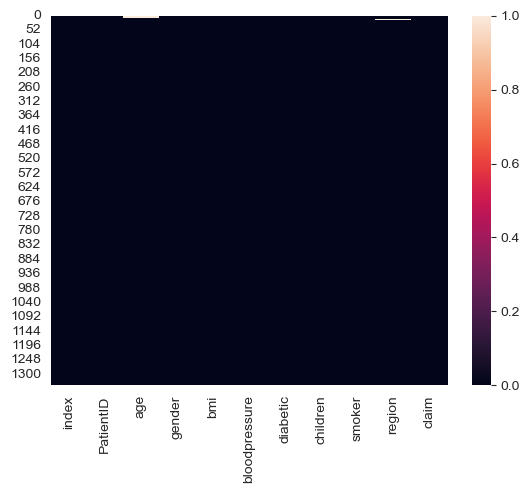

In [23]:
sns.heatmap(df.isnull())

In [24]:
(df.isna().sum() / len(df)) * 100

index            0.000000
PatientID        0.000000
age              0.373134
gender           0.000000
bmi              0.000000
bloodpressure    0.000000
diabetic         0.000000
children         0.000000
smoker           0.000000
region           0.223881
claim            0.000000
dtype: float64

- Les valeurs manquantes representent moins de `1%` du jeu de données

In [25]:
# --- Valeurs manquantes ---
missing_rows = df[df.isnull().any(axis=1)]
print(f"Lignes avec au moins une valeur manquante : {len(missing_rows)}")

# --- Doublons ---
duplicate_rows = df[df.duplicated()]
print(f"Lignes dupliquées : {len(duplicate_rows)}")

# Suppression (conservative)
df = df.dropna().drop_duplicates()
print("Dimensions après nettoyage :", df.shape)

Lignes avec au moins une valeur manquante : 8
Lignes dupliquées : 0
Dimensions après nettoyage : (1332, 11)


> **Pourquoi ne pas toujours imputer ?**
>
> * Dans l’assurance santé, remplacer une tension manquante par la moyenne peut masquer un risque réel.
> * Pour un exercice pédagogique, il est plus simple de supprimer – mais retenez qu’en production on privilégie l’imputation supervisée ou la collecte de données manquantes auprès de l’assuré.

## 4. Âge, genre et montant des sinistres
Les assureurs vérifient souvent si le **coût moyen** évolue avec l’âge et diffère selon le genre.

In [26]:
df.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

In [37]:
df['bmi'].max()

53.1

In [32]:
numerical=df.select_dtypes(exclude='object')

<Axes: >

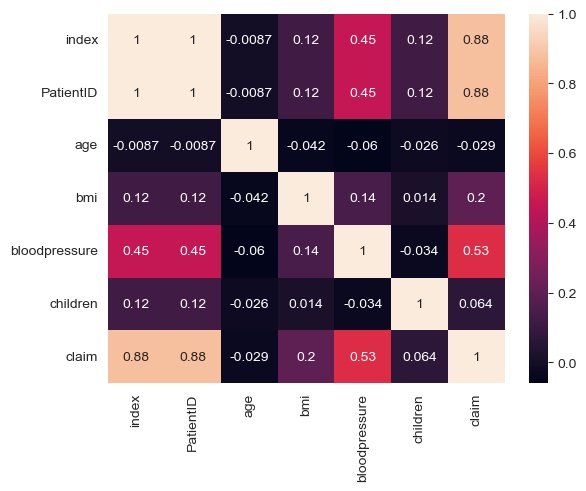

In [ ]:
sns.heatmap(numerical.corr(), annot=True) 

In [38]:
# Corrélation linéaire âge ↔ charges
age_claim_corr = df['age'].corr(df['claim'])
print(f"Corrélation âge / charges : {age_claim_corr:.3f}")

Corrélation âge / charges : -0.029


In [39]:
# Statistiques par genre
stats_genre = df.groupby('gender')['claim'].agg(mean='mean', median='median', count='size')
stats_genre

,mean,median,count
gender,,,
female,12569.578897,9412.965,662
male,14071.891060,9439.495,670


### Visualisation

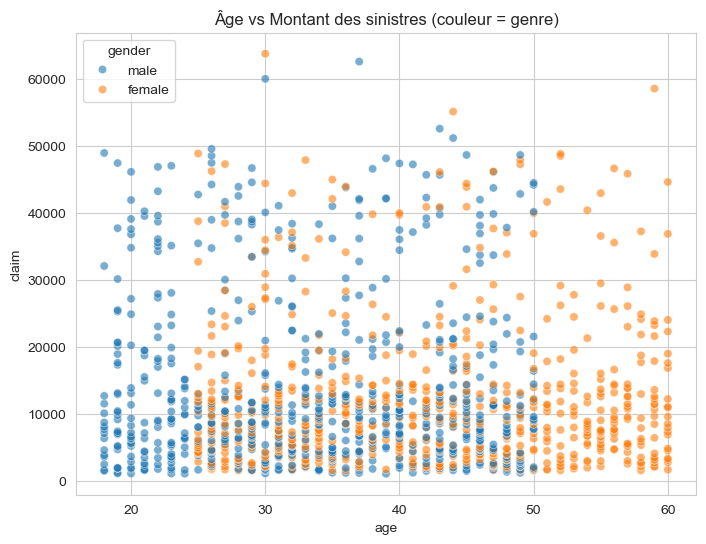

/var/folders/8f/x3gnhxrs2mv8f434z6w6qyw40000gn/T/ipykernel_57823/3821631342.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')


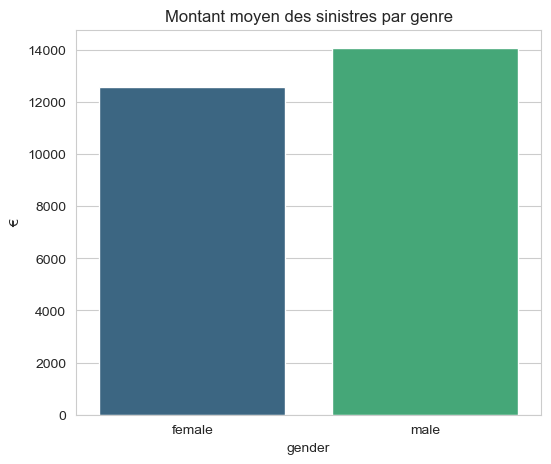

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='claim', hue='gender', data=df, alpha=0.6)
plt.title('Âge vs Montant des sinistres (couleur = genre)')
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')
plt.title('Montant moyen des sinistres par genre')
plt.ylabel('€')
plt.show()

**Interprétation :**
* Un coefficient proche de 0 signifie peu ou pas de relation **linéaire**. D’autres formes (non‑linéaires) peuvent exister.
* Si les hommes ont un coût moyen plus élevé, cela peut venir de comportements de risque (tabagisme, IMC, etc.).


## 5. IMC, tension artérielle et sinistres
L’IMC et la tension sont deux indicateurs de santé clés.
* **IMC élevé** : risque d’obésité → maladies cardiovasculaires ⇒ coûts élevés.
* **Hypertension** : facteur de risque majeur pour AVC / infarctus.

In [48]:
corr_age = df['age'].corr(df['bloodpressure'])
corr_bmi = df['bmi'].corr(df['claim'])
corr_bp  = df['bloodpressure'].corr(df['claim'])
print(f"Corrélation IMC / charges : {corr_bmi *100:.2f} %")
print(f"Corrélation tension / charges : {corr_bp*100:.2f} %")
print(f"Corrélation age / tension arterielle : {corr_age*100:.2f} %")

Corrélation IMC / charges : 19.99 %
Corrélation tension / charges : 53.13 %
Corrélation age / tension arterielle : -6.03 %


In [49]:
df.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

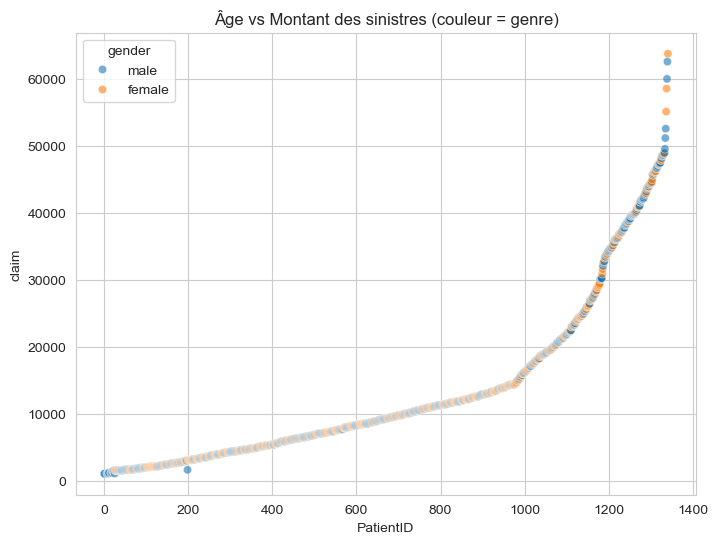

/var/folders/8f/x3gnhxrs2mv8f434z6w6qyw40000gn/T/ipykernel_57823/2277811781.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')


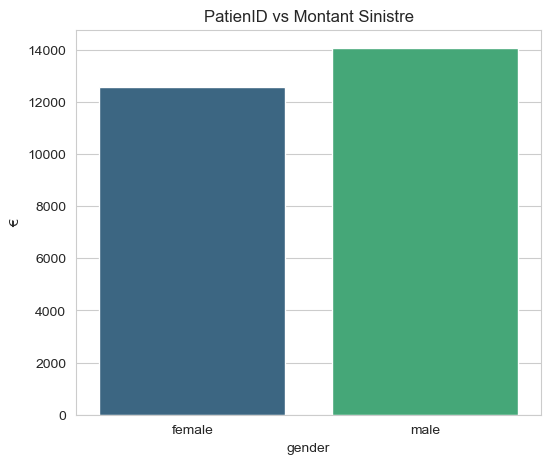

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PatientID', y='claim', hue='gender', data=df, alpha=0.6)
plt.title('Âge vs Montant des sinistres (couleur = genre)')
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')
plt.title('PatienID vs Montant Sinistre')
plt.ylabel('€')
plt.show()

In [54]:
df.tail(10)

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
1330,1330,1331,25.0,female,38.1,111,No,0,Yes,southeast,48885.14
1331,1331,1332,18.0,male,41.1,104,No,1,Yes,southeast,48970.25
1332,1332,1333,26.0,male,37.0,120,No,2,Yes,southeast,49577.66
1333,1333,1334,44.0,male,36.4,127,No,1,Yes,southwest,51194.56
1334,1334,1335,43.0,male,32.8,125,No,0,Yes,southwest,52590.83
1335,1335,1336,44.0,female,35.5,88,Yes,0,Yes,northwest,55135.40
1336,1336,1337,59.0,female,38.1,120,No,1,Yes,northeast,58571.07
1337,1337,1338,30.0,male,34.5,91,Yes,3,Yes,northwest,60021.40
1338,1338,1339,37.0,male,30.4,106,No,0,Yes,southeast,62592.87
1339,1339,1340,30.0,female,47.4,101,No,0,Yes,southeast,63770.43


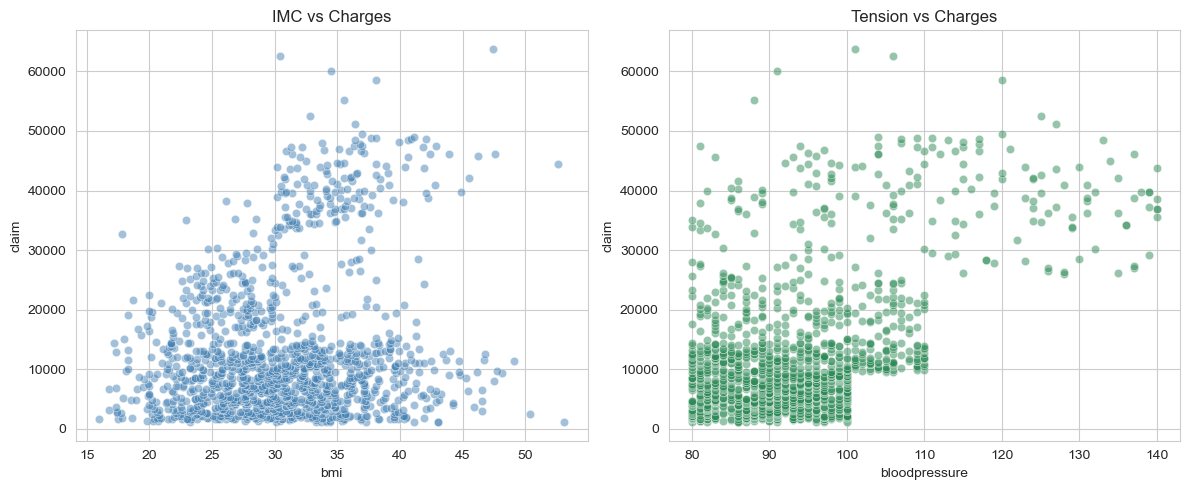

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(data=data, x='bmi', y='claim', alpha=0.5, color='steelblue')
plt.title('IMC vs Charges')
plt.subplot(1,2,2)
sns.scatterplot(data=data, x='bloodpressure', y='claim', alpha=0.5, color='seagreen')
plt.title('Tension vs Charges')
plt.tight_layout()
plt.show()

On observe généralement une relation **positive** : plus l’IMC ou la tension augmentent, plus le coût des sinistres tend à croître. Ces informations sont utilisées dans les **questionnaires de santé** pour ajuster la prime.

In [57]:
# Statistiques par genre
stats_genre = df.groupby('gender')['bloodpressure'].agg(mean='mean', median='median', count='size')
stats_genre

,mean,median,count
gender,,,
female,94.013595,93.0,662
male,94.362687,92.0,670


## 6. Impact du tabagisme
Le tabagisme est souvent la variable la plus discriminante pour les assureurs santé.

In [58]:
data.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

In [59]:
data.sample(5)

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
492,492,493,27.0,male,30.9,91,No,3,No,northwest,6796.86
539,539,540,51.0,female,26.4,97,No,0,No,northwest,7419.48
266,266,267,53.0,female,28.9,93,No,0,No,southeast,3972.92
509,509,510,50.0,female,20.0,89,Yes,2,No,southeast,7133.90
915,915,916,49.0,female,18.3,82,Yes,0,No,northeast,13204.29


In [60]:
mean_smoker = df.loc[df['smoker']=='Yes','claim'].mean()
mean_nonsmoker = df.loc[df['smoker']=='No','claim'].mean()
print(f"Coût moyen fumeurs    : {mean_smoker:,.2f} €")
print(f"Coût moyen non‑fumeurs : {mean_nonsmoker:,.2f} €")

df['smoker_bin'] = df['smoker'].map({'No':0,'Yes':1})
corr_smoker = df['smoker_bin'].corr(df['claim'])
print(f"Corrélation (binaire) tabagisme / charges : {corr_smoker:.3f}")

Coût moyen fumeurs    : 32,050.23 €
Coût moyen non‑fumeurs : 8,475.86 €
Corrélation (binaire) tabagisme / charges : 0.787


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


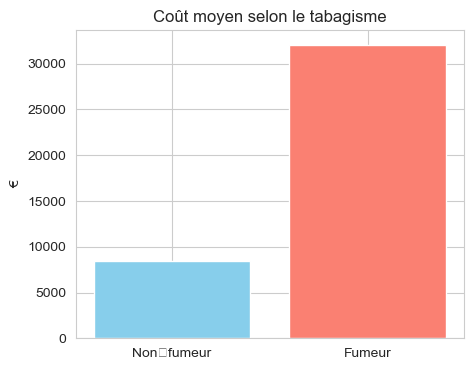

In [61]:
plt.figure(figsize=(5,4))
plt.bar(['Non‑fumeur','Fumeur'], [mean_nonsmoker, mean_smoker], color=['skyblue','salmon'])
plt.title('Coût moyen selon le tabagisme')
plt.ylabel('€')
plt.show()

La corrélation élevée (> 0.7) indique que **fumer augmente fortement le coût des soins**.

> Dans certains pays, les assureurs appliquent une surprime ou imposent un délai de carence aux fumeurs.

## 7. Importance des variables avec Random Forest
Pour prédire le coût (`charges`), nous souhaitons connaître les variables les plus utiles. La **Forêt Aléatoire** fournit un score d’importance basé sur la réduction d’impureté.

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Encodage des colonnes catégorielles
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop(columns=['claim'])
y = df['claim']

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

RandomForestRegressor(n_estimators=300, random_state=42)

In [63]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

PatientID        5.029484e-01
index            4.968701e-01
age              4.357907e-05
bmi              4.090678e-05
bloodpressure    3.358836e-05
region           3.029703e-05
children         2.063533e-05
gender           6.914092e-06
diabetic         4.003952e-06
smoker           7.971053e-07
smoker_bin       7.686051e-07
dtype: float64

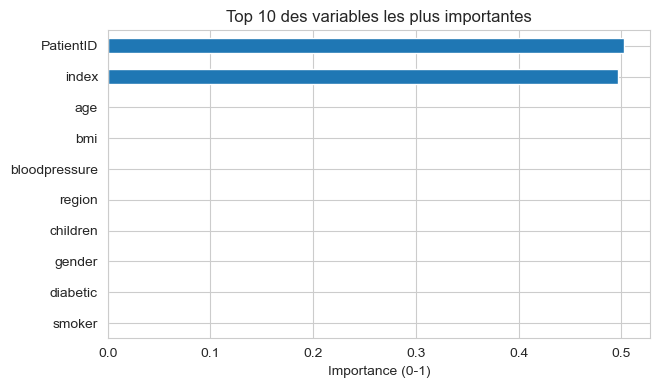

In [64]:
plt.figure(figsize=(7,4))
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 des variables les plus importantes')
plt.xlabel('Importance (0-1)')
plt.show()

**Comment utiliser cette information ?**
* Donner plus de poids aux variables clés dans la tarification.
* Réduire la dimensionnalité (simplifier le questionnaire client).
* Communiquer sur les facteurs de risque majeurs auprès des assurés.

# Modelisation :

Après avoir étudié l’impact de chaque variable et extrait les facteurs clés, 
passons maintenant à la **prédiction avancée** avec deux algorithmes de boosting d’arbres :

* **XGBoost** – souvent champion des compétitions Kaggle, robuste aux interactions non linéaires.
* **LightGBM** – implémentation Microsoft, très rapide et efficace sur gros volumes.

Nous réutiliserons le jeu de données nettoyé et encodé, puis comparerons leurs performances (MAE, R²).

## Encodage des variables catégorielles

In [65]:
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

## Split train / test

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X = df.drop(columns=['claim'])
y = df['claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

## Modèle XGBoost (Extreme Gradient Boosting)

### 1. Principe général

| 🔍                 | Description                                                                                                                                        |
| ------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Boosting**       | Entraîne une succession d’arbres de décision **faibles** ; chaque nouvel arbre corrige les erreurs cumulées des précédents.                        |
| **Gradient**       | L’erreur résiduelle est minimisée : on calcule le **gradient** (dérivée) de la fonction perte pour savoir dans quelle direction ajuster le modèle. |
| **Regularisation** | Ajoute un terme de pénalité (L1/L2) sur la complexité de l’arbre pour éviter l’overfitting.                                                        |
| **Parallélisme**   | Construction des arbres optimisée (histogram-based + multi-thread) → entraînement rapide même sur gros jeux de données.                            |

### 2. Pourquoi XGBoost est performant sur les sinistres ?

* **Relations non linéaires** : le coût d’un sinistre santé n’est pas strictement linéaire (effet multiplicatif entre âge, IMC, tabagisme…). Les arbres gèrent ces interactions naturellement.
* **Robuste aux valeurs aberrantes** : quelques cas de sinistres très chers (queue heavy-tailed) n’influencent pas outre mesure la prédiction globale.
* **Gestion du déséquilibre** : paramètre `scale_pos_weight` (en classification) ou pondérations par observation pour sur-représenter les sinistres rares mais coûteux.
* **Importance des variables** : fournit des scores « gain » ou « cover » utiles pour expliquer la tarification.

### 3. Avantages

| ✅                             | Détails                                                                 |
| ----------------------------- | ----------------------------------------------------------------------- |
| **Excellente précision**      | Souvent vainqueur de compétitions Kaggle et benchmarks industriels.     |
| **Contrôle overfitting**      | Paramètres `gamma`, `lambda`, `alpha`, `subsample`…                     |
| **Feature importance**        | Facile à extraire et à visualiser (gain, cover, weight).                |
| **Tolère données manquantes** | Choisit automatiquement la meilleure direction de branchement pour NaN. |

### 4. Inconvénients / limites

| ⚠️                           | Impact                                                                                                             |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **Hyperparamètres nombreux** | GridSearch long ; nécessite une bonne maîtrise pour équilibrer biais/variance.                                     |
| **Taille mémoire**           | Modèles volumineux avec beaucoup d’arbres → empreinte RAM plus élevée qu’un modèle linéaire.                       |
| **Explicabilité partielle**  | Importance globale OK, mais explication locale moins intuitive qu’une régression logistique (nécessite SHAP/LIME). |

In [68]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

In [69]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=4,
                   subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print('MAE XGB:', mean_absolute_error(y_test, pred_xgb))
print('R² XGB :', r2_score(y_test, pred_xgb))

MAE XGB: 135.20602017863408
R² XGB : 0.9988208233710018


## LightGBM

## Modèle LightGBM (Light Gradient Boosting Machine)

### 1. Principe général

| 🔍                     | Description                                                                                                                                                         |
| ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Leaf-Wise Growth**   | Contrairement à XGBoost (level-wise), LightGBM grandit d’abord **la branche la plus prometteuse** (leaf-wise) → perte réduite plus vite.                            |
| **Histogram-Based**    | Les valeurs continues sont discrétisées en bacs ; accélère le tri et réduit la mémoire.                                                                             |
| **GOSS & EFB**         | *Gradient-Based One-Side Sampling* sélectionne les instants ayant les gradients les plus grands ; *Exclusive Feature Bundling* compacte les features peu corrélées. |
| **Catégories natives** | Accepte des entiers représentant les modalités sans one-hot, en appliquant un regroupement optimal.                                                                 |

### 2. Pourquoi LightGBM brille pour le pricing sinistre ?

* **Rapidité** : permet des itérations rapides sur de gros portefeuilles (millions de contrats).
* **Scalabilité verticale** : moins gourmand en mémoire → entraîne un modèle complet sur un laptop étudiant.
* **Gestion des interactions** : comme XGBoost, capture efficacement les effets combinatoires (ex. région × catégorie socio-pro) impactant le coût.
* **Support des variables catégorielles** : évite le *curse of dimensionality* dû au one-hot (ex. 50 régions → 50 colonnes).

### 3. Avantages

| ✅                                      | Détails                                                               |
| -------------------------------------- | --------------------------------------------------------------------- |
| **Entraînement ultra-rapide**          | 5-10× plus vite qu’un Gradient Boosting classique.                    |
| **Moins de mémoire**                   | Histogram & EFB réduisent l’usage RAM.                                |
| **Performances comparables à XGBoost** | Souvent équivalentes, parfois supérieures sur grands jeux de données. |
| **Paramètres intuitifs**               | `num_leaves`, `max_depth`, `learning_rate` — tuning plus léger.       |

### 4. Inconvénients / limites

| ⚠️                          | Impact                                                                              |
| --------------------------- | ----------------------------------------------------------------------------------- |
| **Leaf-wise → Overfitting** | Peut sur-apprendre si `num_leaves` est trop grand ou `min_data_in_leaf` trop petit. |
| **Support GPU partiel**     | Accelerations GPU disponibles mais moins matures que XGBoost.                       |
| **Interprétation locale**   | Même besoin d’outils SHAP pour expliquer chaque prédiction.                         |

---

## Choisir entre XGBoost et LightGBM

| Critère                    | XGBoost                   | LightGBM                                 |
| -------------------------- | ------------------------- | ---------------------------------------- |
| **Vitesse entraînement**   | Rapide mais plus lent     | ⚡ Très rapide                            |
| **Tuning hyperparamètres** | Plus nombreux             | Moins nombreux                           |
| **Robustesse NaN**         | Automatique               | Automatique                              |
| **Catégories natives**     | Non (nécessite encodage)  | Oui                                      |
| **Mémoire**                | Plus élevée               | Plus faible                              |
| **Explicabilité**          | Importance globale & SHAP | Importance globale & SHAP                |
| **Précision**              | Excellent                 | Équivalent ou meilleur sur gros datasets |

---


> **En pratique :**
>
> * Sur un **jeu de données modeste** (≤ 100 k lignes), les deux donnent souvent des résultats similaires ; XGBoost peut être plus simple à expliquer grâce à sa large documentation.
> * Sur un **portefeuille massif** (≥ 1 M de polices) ou avec un temps de calcul limité, **LightGBM** est souvent préféré.
> * Le choix final doit considérer : délai d’entraînement, contraintes mémoire, besoin de support GPU, facilité d’intégration et niveau d’interprétabilité requis par la conformité.

In [70]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=400, learning_rate=0.05, random_state=42)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_test)
print('MAE LGBM:', mean_absolute_error(y_test, pred_lgbm))
print('R² LGBM :', r2_score(y_test, pred_lgbm))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13337.716900
MAE LGBM: 169.56355036715937
R² LGBM : 0.996823776908425


### Comparaison XGBoost et LightGBM

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time, numpy as np

In [72]:
def evaluate(model, X_train, X_test, y_train, y_test, name="model"):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2   = r2_score(y_test, preds)
    
    return {"Modèle": name,
            "MAE (€)": mae,
            "RMSE (€)": rmse,
            "R²": r2,
            "Train_time (s)": train_time}

results = []
results.append(evaluate(xgb,  X_train, X_test, y_train, y_test, "XGBoost"))
results.append(evaluate(lgbm, X_train, X_test, y_train, y_test, "LightGBM"))

pd.DataFrame(results).set_index("Modèle").style.format({"MAE (€)": "{:,.0f}",
                                                        "RMSE (€)": "{:,.0f}",
                                                        "Train_time (s)": "{:.1f}"})


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13337.716900


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE (€),RMSE (€),R²,Train_time (s)
Modèle,,,,
XGBoost,135,412,0.998821,0.5
LightGBM,170,677,0.996824,2.2


- ### Validation croisée

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_cv_xgb  = -cross_val_score(xgb,  X, y, cv=cv, scoring="neg_mean_absolute_error")
mae_cv_lgbm = -cross_val_score(lgbm, X, y, cv=cv, scoring="neg_mean_absolute_error")

print("XGB  MAE CV  :", mae_cv_xgb.mean(), "±", mae_cv_xgb.std())
print("LGBM MAE CV :", mae_cv_lgbm.mean(), "±", mae_cv_lgbm.std())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13337.716900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13329.679005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

- ### Vérifier l’importance des variables & l’explicabilité

In [ ]:
!pip install shap -q

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb)   # ou lgbm
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)   # importance + direction


- ### Alternative rapide (sans shap)

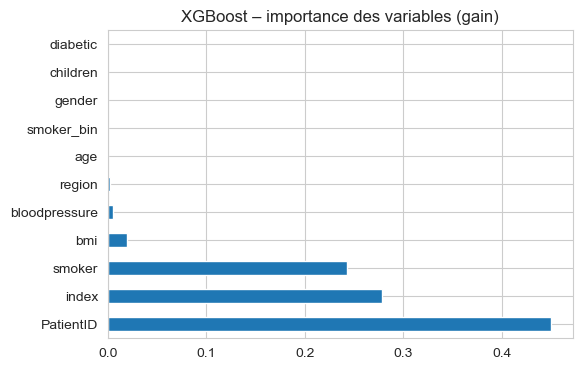

In [74]:
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='barh', figsize=(6,4))
plt.title("XGBoost – importance des variables (gain)")
plt.show()

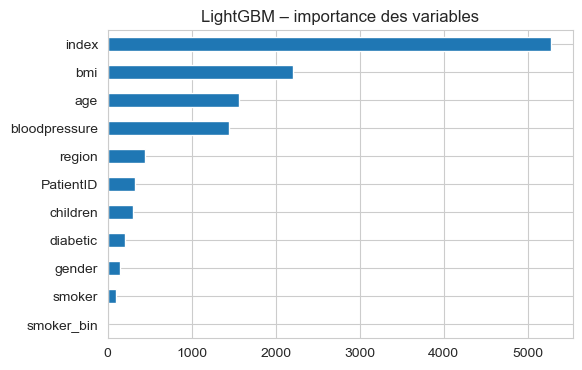

In [75]:
importances_lgbm = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values()
importances_lgbm.plot(kind='barh', figsize=(6,4))
plt.title("LightGBM – importance des variables")
plt.show()